In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


4720


In [11]:
# importing the datas sample
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [13]:
# sample of what the collated data looks like
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0


In [14]:
df.info

<bound method DataFrame.info of        user_id                   timestamp      group landing_page  converted
0       851104  2017-01-21 22:11:48.556739    control     old_page        0.0
1       804228  2017-01-12 08:01:45.159739    control     old_page        0.0
2       661590  2017-01-11 16:55:06.154213  treatment     new_page        0.0
3       853541  2017-01-08 18:28:03.143765  treatment     new_page        0.0
4       864975  2017-01-21 01:52:26.210827    control     old_page        1.0
...        ...                         ...        ...          ...        ...
38828   694106  2017-01-19 16:49:22.405753    control     old_page        0.0
38829   919276  2017-01-15 17:36:27.425782  treatment     new_page        0.0
38830   900701  2017-01-16 10:11:38.989001  treatment     new_page        0.0
38831   668013  2017-01-18 14:33:05.371081    control     old_page        0.0
38832   677689  2017-01-08 03:22:17.415002  treatment          NaN        NaN

[38833 rows x 5 columns]>

In [15]:
# the dataset contains users that have experienced both the new and old pages.
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,267,19082
treatment,19207,276


In [16]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 76 users that appear multiple times in the dataset


In [17]:
# we drop the second time the instance used the homepage
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 38681 entries


In [18]:
# the dataset is now cleaner as can see the user experience only one page
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,229,19039
treatment,19173,239


In [19]:
# here we collated the required n from each group as defined earlier

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22) 
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,931877,2017-01-11 00:28:22.096052,control,old_page,0.0
1,851347,2017-01-03 10:08:13.895233,control,old_page,0.0
2,827461,2017-01-04 19:28:27.417197,control,old_page,1.0
3,909017,2017-01-06 05:52:04.522807,control,old_page,0.0
4,809821,2017-01-12 00:13:17.249693,control,old_page,0.0
...,...,...,...,...,...
9435,842030,2017-01-22 07:11:34.217495,treatment,new_page,1.0
9436,729804,2017-01-23 11:52:45.913579,treatment,new_page,0.0
9437,928993,2017-01-16 15:18:20.987052,treatment,new_page,0.0
9438,894315,2017-01-04 16:18:55.379061,treatment,new_page,0.0


In [20]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       9440 non-null   int64  
 1   timestamp     9440 non-null   object 
 2   group         9440 non-null   object 
 3   landing_page  9440 non-null   object 
 4   converted     9440 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 368.9+ KB


In [21]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [22]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.131,0.338,0.005
treatment,0.123,0.329,0.005


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


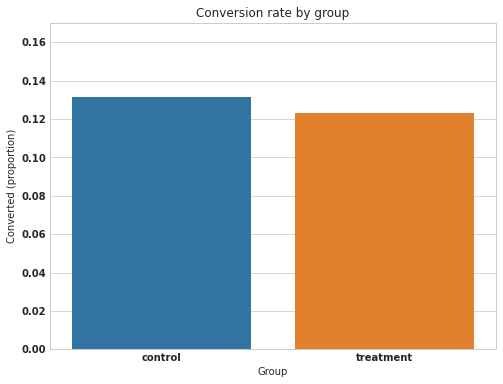

In [23]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

In [24]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.17
p-value: 0.241
ci 95% for control group: [0.122, 0.141]
ci 95% for treatment group: [0.114, 0.133]
